In [1]:
import sisl
from hubbard import HubbardHamiltonian, sp2, density, plot, NEGF
import matplotlib.pyplot as plt
%matplotlib inline

# Open quantum systems (Green's functions)

In this example we will study the effect of Coulomb repulsion interactions in an open-quantum system, and find the self-consistent solution using the non-equilibrium Green's function (NEGF) formalism within the `hubbard` package.

The sysem of this example is composed by a central region coupled to two electrodes (left and right). 
The central region in this case will be just a repetition of the unit-cell of the electrodes (perfect system),
for the sake of simplicity. We will consider the electrodes to be the unit cell of a zigzag graphene nanoribbon (ZGNR) periodic along the x-axis of width W=5 C-atoms across.

We will focus on the equilibrium situation, therefore the temperature and chemical potentials of the electrodes *must coincide*.
The complex contour that we use to integrate the density matrix in the `hubbard.NEGF` class is extracted from a [Transiesta](https://gitlab.com/siesta-project/siesta) calculation
performed for a temperature of `kT=0.025` eV, which we will set as common for all the composing element calculations.

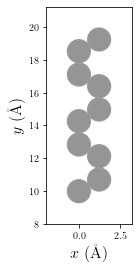

In [2]:
# Build sisl.Geometry object
geom = sisl.geom.zgnr(5)

# Plot geometry of the unit cell
p = plot.GeometryPlot(geom, cmap='Greys',figsize=(2,4))

To build the TB Hamiltonian (which describes the kinetic part of the system's Hamiltonian) we will use the function from the `hubbard` package `sp2` that builds the TB `sisl.Hamiltonian` of an sp2 carbon system. We will use the first nearest neighbors interactions (1NN) TB model, typically used to simulate graphene.

In [3]:
# Build sisl.Hamiltonian object using the sp2 function
H_elec = sp2(geom, t1=2.7, t2=0.2, t3=0.18, spin='polarized')

Now we build the `HubbardHamiltonian` object for the electrodes. As in [this example](https://dipc-cc.github.io/hubbard/docs/latest/examples/periodic.html), one needs to pass the argument `nkpt=[nkx,nky,nkz]` to sample the Hamiltonian along the periodic directions in k-space. To model the interaction part (Hubbard term) we will use `U=3.` eV

In [4]:
# Build the HubbardHamiltonian object with U=3. eV
MFH_elec = HubbardHamiltonian(H_elec, U=3., nkpt=[100,1,1], kT=0.025)

As in [this example](https://dipc-cc.github.io/hubbard/docs/latest/examples/molecules.html) one has to break symmetry between up and down electrons so the program can find a self-consistent solution. To do so we can place one up electron at the lower edge of the ribbon and one down electron on the upper edge of the ribbon.

In [5]:
MFH_elec.set_polarization([0], dn=[-1])

Now we can start the convergence until we find the self-consistent solution up to a desired tolerance (`tol`) by calling the `HubbardHamiltonian.converge` method. This method needs of another method to tell the code how to build the spin-densities. For instance, to compute the spin-densities for TB Hamiltonians with finite or periodic boundary conditions, one could use the method `density.calc_n` of the `hubbard` package.

In [6]:
# Converge until a tolerance of tol=1e-10, print info for each 10 completed iterations
dn = MFH_elec.converge(density.calc_n, tol=1e-10, print_info=True, steps=10)

   HubbardHamiltonian: converge towards tol=1.00e-10
   10 iterations completed: 2.6818192494504345e-07 -62.28270704875
   found solution in 14 iterations


Let's visualize some relevant physical quantities of the final result

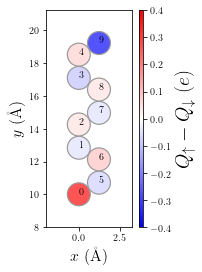

In [7]:
p = plot.SpinPolarization(MFH_elec, colorbar=True, vmax=0.4, vmin=-0.4, figsize=(2,4))
p.annotate(size=10);

Let's also plot the bandstructure of the electrodes

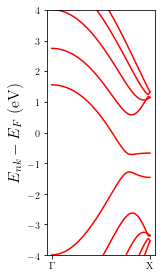

In [8]:
p = plot.Bandstructure(MFH_elec, ymax=4, figsize=(2,4))

Build central region TB Hamiltonian as a repetition of the electrodes, but without periodic boundary conditions

In [9]:
# Central region is a repetition of the electrodes
HC = H_elec.tile(3,axis=0)
# without periodic boundary conditions
HC.set_nsc([1,1,1])

 In this case we will have to use a method based on the non-equilibrium Green's function of the central region 
 to obtain the spin-densities. To do so, we can make use of the methods available in the `hubbard.NEGF` class.
   
 1. Build HubbardHmamiltonian for the non-periodic device
 2. Build NEGF object for the device by passing:
     - The HubbardHamiltonian of the device
     - A list of tuples containing the electrode Hamiltonians and their respective semi-infinite directions:    `[(Helec1, dir1), (Helec2, dir2), ...]`
     - The atomic positions of the electrodes inside the device (`elec_indx`)
 3. Converge the HubbardHamiltonian using the `NEGF.calc_n_open` method to obtain the spin densities for the open-quantum system

In [10]:
# MFH object of the central region, same kT and U as electrodes!
MFH_HC = HubbardHamiltonian(HC, U=3., kT=0.025)

# Use initial random density
MFH_HC.random_density()

# Map electrodes in the device region, i.e., extract the atomic indices that correspond
# to the electrodes inside the device region. In this case the first and last blocks
elec_indx = [range(len(H_elec)), range(-len(H_elec), 0)]

# First create the NEGF object, where we pass the MFH converged electrodes and
# the central region HubbardHamiltonian object
negf = NEGF(MFH_HC, [(MFH_elec, '-A'), (MFH_elec, '+A')], elec_indx)

# Converge using Green's function method to obtain the densities
dn = MFH_HC.converge(negf.calc_n_open, steps=1, tol=1e-6, print_info=True)

   HubbardHamiltonian: converge towards tol=1.00e-06
   1 iterations completed: 0.4808373837433086 -141.68364233284112
   2 iterations completed: 0.18293016068416684 -186.84361242456043
   3 iterations completed: 0.051316852264032264 -186.8017408714892
   4 iterations completed: 0.02488107302253495 -186.81281579788273
   5 iterations completed: 0.0038729870669934607 -186.8415493962869
   6 iterations completed: 0.002376656285169698 -186.8468393262589
   7 iterations completed: 0.0003524184624972282 -186.8479471423146
   8 iterations completed: 7.085002878826074e-05 -186.84806174466465
   9 iterations completed: 9.511403021966736e-06 -186.84810104924318
   10 iterations completed: 2.6608195501931498e-06 -186.84809098450492
   11 iterations completed: 3.514672604065794e-07 -186.84808764264898
   found solution in 11 iterations


Let's visualize the spin polarization of the device

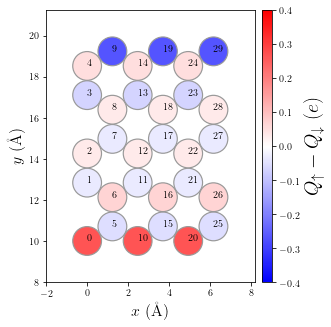

In [11]:
p = plot.SpinPolarization(MFH_HC, colorbar=True, vmax=0.4, vmin=-0.4, figsize=(6,5))
p.annotate(size=10)

Write electrode and device Hamiltonians to netCDF files so TBtrans can read them

In [12]:
# Shift electrodes with Fermi level and write it to nc file
MFH_elec.shift(-MFH_elec.fermi_level())
MFH_elec.H.write('MFH_elec.nc')

# Shift device with its Fermi level and write nc file
MFH_HC.H.write('MFH_HC.nc', Ef=negf.Ef)

Write the input file for a [TBtrans](https://gitlab.com/siesta-project/siesta) calculation for this system

In [13]:
f = open('RUN.fdf', 'w')
f.write(
"""SystemLabel device
TBT.HS MFH_HC.nc

%block TBT.Contours
  window
%endblock

%block TBT.Contour.window
 part line
   from -10.0 eV to 10.0 eV
    delta 0.01 eV
     method mid-rule
%endblock

%block TS.Elecs
  LEFT
  RIGHT
%endblock TS.Elecs

%block TS.Elec.LEFT
  TSHS MFH_elec.nc
  semi-inf-dir -a1
  elec-pos begin 1
%endblock TS.Elec.LEFT

%block TS.Elec.RIGHT
  TSHS MFH_elec.nc
  semi-inf-dir +a1
  elec-pos end -1
%endblock TS.Elec.RIGHT
"""
       )
f.close()

Clean possible previous TBtrans output files and run again

In [14]:
# TBtrans calculation
import os
# Clean output
os.system('rm device.TBT*')
os.system('rm fdf*')
# Run TBtrans
os.system('tbtrans RUN.fdf > RUN.out')

0

Extract data from [TBtrans](https://gitlab.com/siesta-project/siesta) calculation for each spin channel using [sisl](https://github.com/zerothi/sisl)

In [15]:
tbt_up = sisl.get_sile('device.TBT_UP.nc')
tbt_dn = sisl.get_sile('device.TBT_DN.nc')

Plot transmission probabilities for each spin channel 

Text(0, 0.5, 'Transmission [a.u.]')

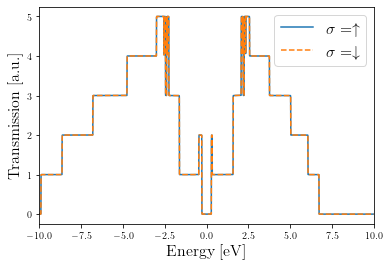

In [16]:
plt.plot(tbt_up.E, tbt_up.transmission(0, 1), label=r'$\sigma=\uparrow$')
plt.plot(tbt_dn.E, tbt_dn.transmission(0, 1), '--', label=r'$\sigma=\downarrow$')
plt.legend(fontsize=16)
plt.xlim(-10, 10)
plt.xlabel('Energy [eV]', fontsize=16)
plt.ylabel('Transmission [a.u.]', fontsize=16)

#### Note
Usually, each iteration using the non-equilibrium Green's function formalism takes more time than if the system is finite or periodic.
This is due to the fact that it has to invert the Green's function matrix for each energy point along the integration path in each iteration.
For this reason, using a good initial guess (initial spin-densities) can be crucial if we want to improve the performance.

Try again the example from above but using a specific initial guess for the spin-densities.
For instance, you could find the self-consistent solution for the device Hamiltonian with periodic boundary conditions
and use this spin-densities to start the convergence for the device with open boundary conditions.